In [1]:
!git clone https://github.com/hpt1988/Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course

Cloning into 'Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course'...
remote: Enumerating objects: 22214, done.
remote: Counting objects: 100% (22214/22214), done.
remote: Compressing objects: 100% (22126/22126), done.
remote: Total 22214 (delta 133), reused 22142 (delta 75), pack-reused 0
Receiving objects: 100% (22214/22214), 317.95 MiB | 33.42 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Checking out files: 100% (21952/21952), done.


In [4]:
!ls Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course/behavioural_cloning/Data

driving_log.csv  IMG


# Preprocessing

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import ntpath
import random

In [9]:
datadir = 'Applied-Deep-Learning_The-Complete-Self-Driving-Car-Course/behavioural_cloning/Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_154.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_154.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_154.jpg,0.0,0.0,0.0,0.000081
1,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_264.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_264.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_264.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_375.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_375.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_375.jpg,0.0,0.0,0.0,0.000080
3,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_489.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_489.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_489.jpg,0.0,0.0,0.0,0.000079
4,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\center_2021_06_29_11_07_08_596.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\left_2021_06_29_11_07_08_596.jpg,C:\Users\OPU6FE\Documents\KhodroKhodran\simulator-windows-64\Data\IMG\right_2021_06_29_11_07_08_596.jpg,0.0,0.0,0.0,0.000079


In [12]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_06_29_11_07_08_154.jpg,left_2021_06_29_11_07_08_154.jpg,right_2021_06_29_11_07_08_154.jpg,0.0,0.0,0.0,0.000081
1,center_2021_06_29_11_07_08_264.jpg,left_2021_06_29_11_07_08_264.jpg,right_2021_06_29_11_07_08_264.jpg,0.0,0.0,0.0,0.000078
2,center_2021_06_29_11_07_08_375.jpg,left_2021_06_29_11_07_08_375.jpg,right_2021_06_29_11_07_08_375.jpg,0.0,0.0,0.0,0.000080
3,center_2021_06_29_11_07_08_489.jpg,left_2021_06_29_11_07_08_489.jpg,right_2021_06_29_11_07_08_489.jpg,0.0,0.0,0.0,0.000079
4,center_2021_06_29_11_07_08_596.jpg,left_2021_06_29_11_07_08_596.jpg,right_2021_06_29_11_07_08_596.jpg,0.0,0.0,0.0,0.000079


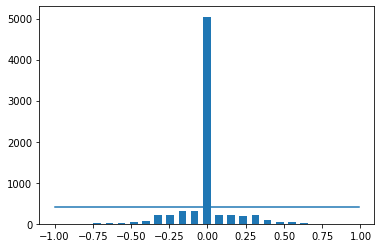

In [16]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))